[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Diaz](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)  


**Image classification using MLP**  

# Deep Learning Shuffled vs Unshuffled with MLP
<!--<badge>--><a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group06/blob/main/Assignments/01-MLP-ShufflingPixels/01-MLP-Shuffle-Pixels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## 1. Import all necessary packages

In [2]:
import itertools

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

# let's try to fix randomness
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

/home/burak/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist]) for image classification and show some samples 
It is also available in [PyTorch datasets](https://pytorch.org/vision/stable/datasets.html) and [TensorFlow datasets](https://www.tensorflow.org/datasets)

### 2.1 Loading the dataset

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    "./fashion_mnist",
    download=True,
    train=True,
    transform=T.ToTensor()
)


test_set = torchvision.datasets.FashionMNIST(
    "./fashion_mnist",
    download=True,
    train=False,
    transform=T.ToTensor()
)

train_set, valid_set = random_split(train_set, [58000, 2000], generator=torch.Generator().manual_seed(42))
print("Train set size", len(train_set))
print("Valid set size", len(valid_set))
print("Test set size", len(test_set))

Train set size 58000
Valid set size 2000
Test set size 10000


## 3. Create a **Multi Layer Perceptron (MLP)** for image classification.

In [4]:
class MLPModel(torch.nn.Module):
    def __init__(self, input_size=28*28):
        super(MLPModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, 128)
        self.linear2 = torch.nn.Linear(128, 128)
        self.linear3 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

## 4. Train the model Unshuffled

In [5]:
# let's try to fix randomness
torch.manual_seed(123)
torch.cuda.manual_seed(123)

loss = torch.nn.CrossEntropyLoss()
model = MLPModel()

optimizer = Adam(model.parameters(), lr=.001) # I also tried .01 and 0.0001
# we want to train in batches
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=512, shuffle=False) # no need to shuffle since we only test on it
loss_per_epoch_tmp = []
accuracy_per_epoch_tmp = []
for epoch in range(10):
    model.train()
    #I tried to overfit the first batch to see if model was ok
    #first_batch = next(iter(train_dataloader))
    #for batch_idx, (images, labels) in enumerate([first_batch] * 50):
    sum_loss = 0.0
    for images, labels in train_dataloader:
        output = model(images)
        loss_batch = loss(output, labels)
        sum_loss += loss_batch.item() * images.shape[0]
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    loss_per_epoch_tmp.append(sum_loss / len(train_set))
    # save weights    
    # torch.save(model.state_dict(), f"./model_states/ep_{epoch}.pth")
    model.eval()
    accuracy = []
    #for batch_idx, (images, labels) in enumerate([first_batch]):
    for images, labels in valid_dataloader:
        output = model(images)
        output = torch.argmax(output, 1)
        accuracy.append(output == labels)
    accuracy = torch.cat(accuracy).double().mean()
    accuracy_per_epoch_tmp.append(accuracy)
    print(f"Epoch {epoch}, Avg loss {loss_per_epoch_tmp[-1]}, Validation set accuracy {accuracy}")
loss_per_epoch = loss_per_epoch_tmp
accuracy_per_epoch = accuracy_per_epoch_tmp

Epoch 0, Avg loss 1.727589510654581, Validation set accuracy 0.81
Epoch 1, Avg loss 1.630965333774172, Validation set accuracy 0.835
Epoch 2, Avg loss 1.616591592953123, Validation set accuracy 0.832
Epoch 3, Avg loss 1.6089180501740554, Validation set accuracy 0.837
Epoch 4, Avg loss 1.6030959619653635, Validation set accuracy 0.8525
Epoch 5, Avg loss 1.5989304000262556, Validation set accuracy 0.8585
Epoch 6, Avg loss 1.5983039103540881, Validation set accuracy 0.8445
Epoch 7, Avg loss 1.5897518673929676, Validation set accuracy 0.8525
Epoch 8, Avg loss 1.5891601454964999, Validation set accuracy 0.8485
Epoch 9, Avg loss 1.5856854871881418, Validation set accuracy 0.855


In [6]:
test_dataloader = DataLoader(test_set, batch_size=512, shuffle=False) # no need to shuffle since we only test on it
test_accuracy = []
for images, labels in test_dataloader:
    output = model(images)
    output = torch.argmax(output, 1)
    test_accuracy.append(output == labels)
test_accuracy = torch.cat(test_accuracy).double().mean()
print(f"Test set accuracy {test_accuracy}")

Test set accuracy 0.8557


# 5. Training and testing with shuffled pixels

We want to see what happens if we shuffle the pixels of every image with the MLP performance. In theory if we shuffle every image in the same way MLP performance should not decrease as it does not care about pixel location.

In [7]:
np.random.seed(42)
shuffle = np.arange(0, 784) # We want to shuffle every image in the same way!
np.random.shuffle(shuffle)
loss = torch.nn.CrossEntropyLoss()

# let's try to fix randomness
torch.manual_seed(123)
torch.cuda.manual_seed(123)

shuffled_model = MLPModel()

optimizer = Adam(shuffled_model.parameters(), lr=.001)
# we want to train in batches
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=512, shuffle=False) # no need to shuffle since we only test on it
loss_per_epoch_tmp_shuff = []
accuracy_per_epoch_tmp_shuff = []
for epoch in range(10):
    shuffled_model.train()
    sum_loss = 0.0
    for images, labels in train_dataloader:
        images = images.detach().clone()
        images = images.reshape(images.shape[0], -1)
        images = images[:, shuffle]
        images = images.reshape(images.shape[0], 1, 28, 28)
        output = shuffled_model(images)
        loss_batch = loss(output, labels)
        sum_loss += loss_batch.item() * images.shape[0]
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    loss_per_epoch_tmp_shuff.append(sum_loss / len(train_set))
    # save weights    
    #torch.save(shuffled_model.state_dict(), f"./model_states/ep_{epoch}.pth")
    shuffled_model.eval()
    accuracy = []
    #for batch_idx, (images, labels) in enumerate([first_batch]):
    for images, labels in valid_dataloader:
        images = images.detach().clone()
        images = images.reshape(images.shape[0], -1)
        images = images[:, shuffle]
        images = images.reshape(images.shape[0], 1, 28, 28)
        output = shuffled_model(images)
        output = torch.argmax(output, 1)
        accuracy.append(output == labels)
    accuracy = torch.cat(accuracy).double().mean()
    accuracy_per_epoch_tmp_shuff.append(accuracy)
    print(f"Epoch {epoch}, Avg loss {loss_per_epoch_tmp[-1]}, Validation set accuracy {accuracy}")
loss_per_epoch_shuff = loss_per_epoch_tmp_shuff
accuracy_per_epoch_shuff = accuracy_per_epoch_tmp_shuff

Epoch 0, Avg loss 1.5856854871881418, Validation set accuracy 0.7465
Epoch 1, Avg loss 1.5856854871881418, Validation set accuracy 0.784
Epoch 2, Avg loss 1.5856854871881418, Validation set accuracy 0.7955
Epoch 3, Avg loss 1.5856854871881418, Validation set accuracy 0.8015
Epoch 4, Avg loss 1.5856854871881418, Validation set accuracy 0.8045
Epoch 5, Avg loss 1.5856854871881418, Validation set accuracy 0.805
Epoch 6, Avg loss 1.5856854871881418, Validation set accuracy 0.7955
Epoch 7, Avg loss 1.5856854871881418, Validation set accuracy 0.809
Epoch 8, Avg loss 1.5856854871881418, Validation set accuracy 0.8115
Epoch 9, Avg loss 1.5856854871881418, Validation set accuracy 0.8065


Both models have similar validation set accuracies. So for MLP if we shuffle every image(including test and validation) in the same way it actually cannot understand the difference. For a convolutional network this would present a challenge.

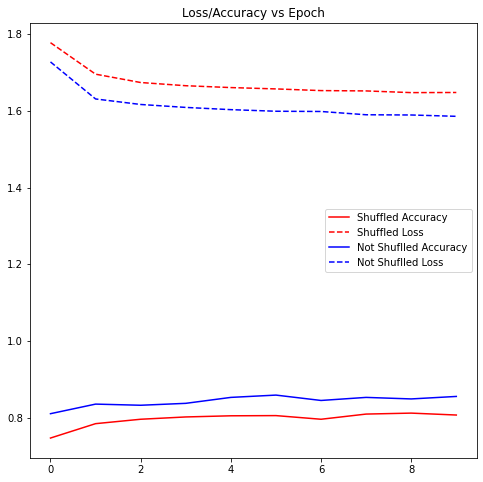

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Loss/Accuracy vs Epoch')
lpes, = ax.plot(loss_per_epoch_shuff, label='Shuffled Loss', linestyle='dashed', color='red')
lpe, = ax.plot(loss_per_epoch, label='Not Shuflled Loss', linestyle='dashed', color='blue')

apes, = ax.plot(accuracy_per_epoch_shuff, label='Shuffled Accuracy', color='red')
ape, = ax.plot(accuracy_per_epoch, label='Not Shuflled Accuracy', color='blue')

ax.legend(handles=[apes, lpes, ape, lpe])

We reason that difference between shuffled and not shuffled is due to randomness in weight initialization